#### Notebook Interpretation

In this notebook, I explored and visualized how batch gradient descent works for a simple linear regression problem using PyTorch and Matplotlib. My aim was to see how the model parameters (weight and bias) are updated during training and how the loss evolves over time.

#### Data Generation

I generated synthetic linear data with added Gaussian noise to simulate a real-world regression scenario. This allowed me to observe how the optimizer behaves when the data is not perfectly linear.

#### Visualization Tools

To gain better intuition, I used a custom class, `plot_error_surfaces`, which visualizes both the loss surface and the trajectory of parameter updates (`w` and `b`) during training. This made it easier to see how the optimizer navigates the parameter space toward the minimum.

#### Model and Loss Function

I defined a simple linear regression model using PyTorch's `nn.Module` and used mean squared error (`nn.MSELoss`) as the loss function. The optimizer used was stochastic gradient descent (SGD).

#### Training with Batch Gradient Descent

- **Batch Gradient Descent (BGD):**  
  I trained the model using the entire dataset for each update (batch size = 1 in the DataLoader). After each epoch, I visualized the parameter updates and the loss surface. The loss decreased steadily, and the parameter updates moved directly toward the minimum.

#### My Observations

- The loss surface visualization helped me understand how the optimizer searches for the minimum.
- Watching the parameter updates on the contour plot gave me a clearer intuition about the optimization process.
- The model parameters (weight and bias) converged toward values that best fit the noisy data.

Overall, this notebook helped me build a stronger intuition for how batch gradient descent works in practice and how parameter updates are reflected on the loss surface during training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help visualize the data space and the parameter space during training and has nothing to do with PyTorch. 

In [2]:
# The class for plotting the diagrams

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)  # Create a range of w values for the grid
        B = np.linspace(-b_range, b_range, n_samples)  # Create a range of b values for the grid
        w, b = np.meshgrid(W, B)    # Create a meshgrid for w and b
        Z = np.zeros((30, 30))      # Initialize a grid for loss values
        count1 = 0
        self.y = Y.numpy()          # Store Y as a numpy array for calculations
        self.x = X.numpy()          # Store X as a numpy array for calculations
        for w1, b1 in zip(w, b):    # Loop over each row in the meshgrid
            count2 = 0
            for w2, b2 in zip(w1, b1):  # Loop over each column in the meshgrid
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)  # Compute MSE loss for each (w, b)
                count2 += 1
            count1 += 1
        self.Z = Z                  # Store the loss surface
        self.w = w                  # Store the w grid
        self.b = b                  # Store the b grid
        self.W = []                 # List to store w values during training
        self.B = []                 # List to store b values during training
        self.LOSS = []              # List to store loss values during training
        self.n = 0                  # Counter for iterations
        if go == True:              # If go is True, plot the surfaces immediately
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Setter to record parameter and loss history
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1         # Increment iteration counter
        self.W.append(W)            # Store current w
        self.B.append(B)            # Store current b
        self.LOSS.append(loss)      # Store current loss
    
    # Plot the 3D loss surface and parameter trajectory
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)  # Plot the loss surface wireframe
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)  # Plot parameter updates
        plt.figure()
        plt.contour(self.w, self.b, self.Z)        # Plot the contour of the loss surface
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')  # Plot parameter updates on contour
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot the data space and parameter space after each update
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim()
        plt.plot(self.x, self.y, 'ro', label = "training points")  # Plot training data
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")  # Plot current model
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Data Space Iteration: '+ str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)  # Plot loss surface contour
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')  # Plot parameter updates
        plt.title('Loss Surface Contour')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

# Generationg some Random Data


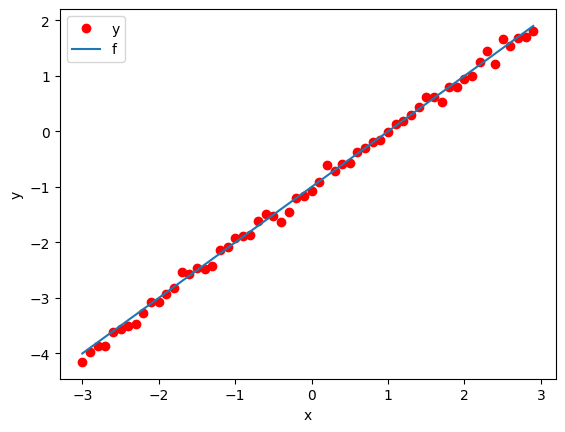

In [3]:
import torch  # Import PyTorch for tensor operations
torch.manual_seed(1)  # Set random seed for reproducibility

# Generate random linear data with noise
X = torch.arange(-3, 3, 0.1).view(-1, 1)  # Create input values from -3 to 3 in steps of 0.1, shape as column vector
f = 1 * X - 1  # Define the true linear relationship: slope=1, intercept=-1
Y = f + 0.1 * torch.randn(X.size())  # Add Gaussian noise (std=0.1) to the true line to simulate real data

# Plotting the data and line
plt.plot(X.numpy(), Y.numpy(), 'ro', label='y')  # Plot noisy data as red dots
plt.plot(X.numpy(), f.numpy(), label='f')        # Plot the true line
plt.xlabel('x')                                  # Label x-axis
plt.ylabel('y')                                  # Label y-axis
plt.legend()                                     # Show legend
plt.show()                                       # Display the plot

# Creating the Model and Total Loss Function(Cost)

In [4]:
# create a linear regression model
from torch import nn, optim

class linear_regression(nn.Module):
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # prediction
    def forward(self, x):
        y_pred = self.linear(x)  # Forward pass through the linear layer
        return y_pred
    
# build in cost function
criterion = nn.MSELoss()  # Mean Squared Error loss function
# build in optimizer
model = linear_regression(1, 1)  # Create a linear regression model with 1 input and 1 output
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer with learning rate 0.01

# list the the parameters
print("Parameters: ", list(model.parameters()))  # Print the model parameters (weights and bias)


Parameters:  [Parameter containing:
tensor([[0.3636]], requires_grad=True), Parameter containing:
tensor([0.4957], requires_grad=True)]


In [5]:
# the optimizer also has a state, which is a dictionary
optimizer.state_dict()  # Get the state dictionary of the optimizer, which contains information about the optimization process

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

<Figure size 640x480 with 0 Axes>

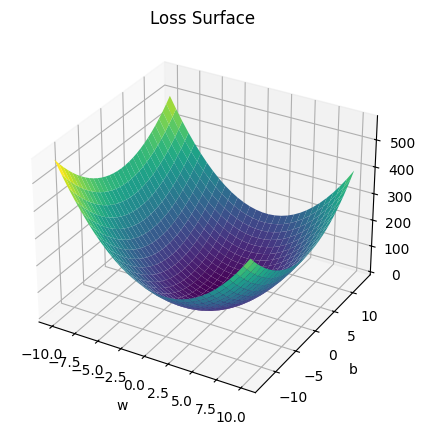

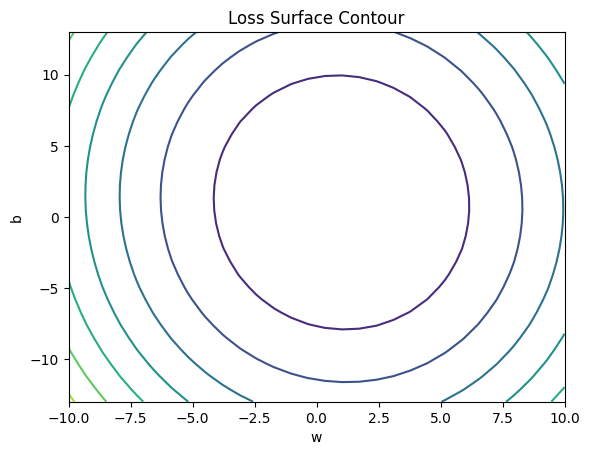

In [8]:
# create the DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Create the dataset from X and Y tensors
dataset = TensorDataset(X, Y)
trainloader = DataLoader(dataset = dataset, batch_size = 1)

# customize the weight and bias range
model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10

# create the plot surface object
get_surfaces = plot_error_surfaces(10, 13, X, Y, 30, go = True)  # Use X, Y directly instead of dataset.x, dataset.y

# Training the Model: Batch Gradient Descent

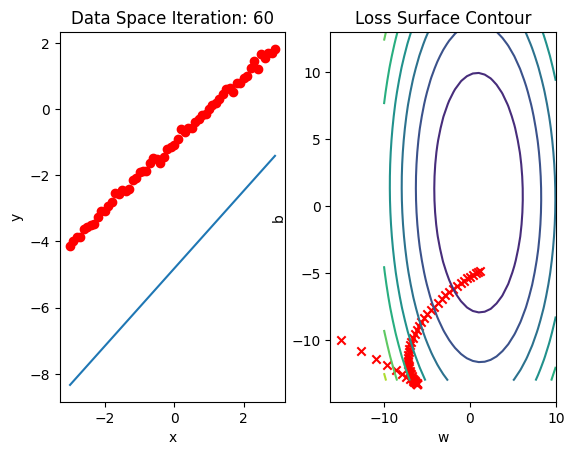

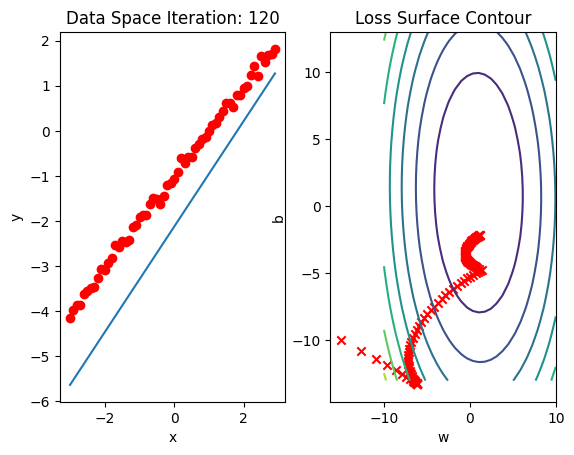

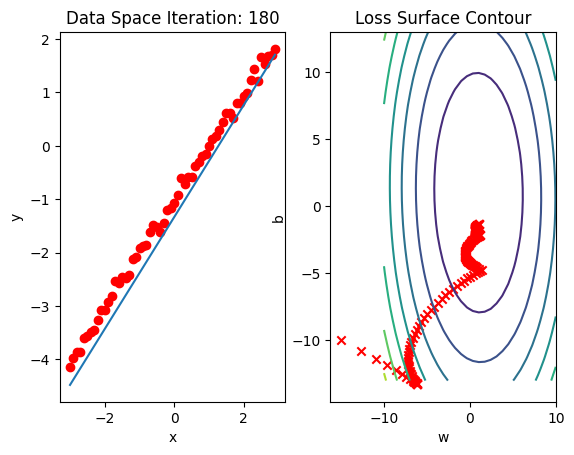

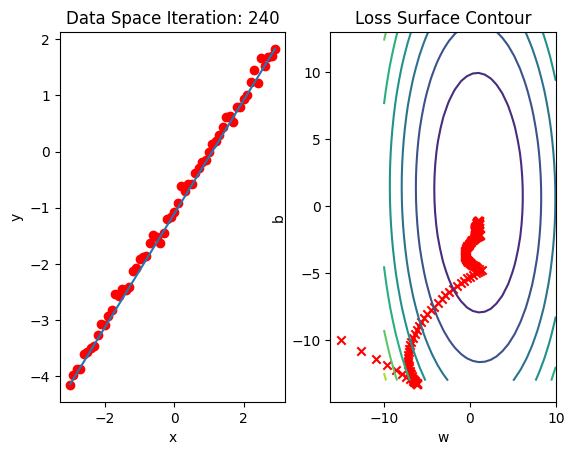

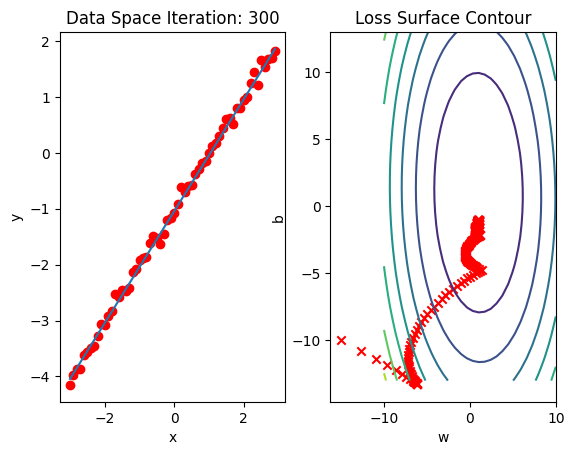

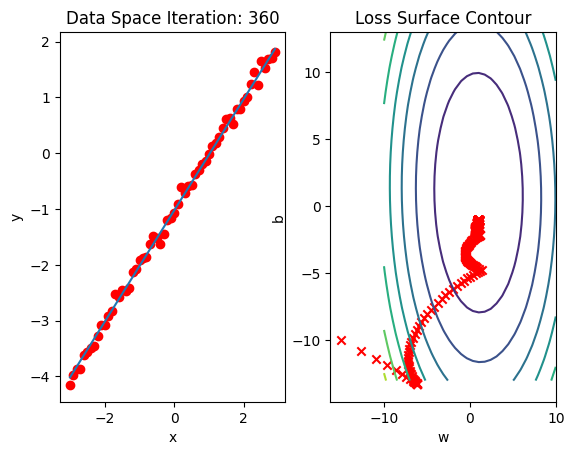

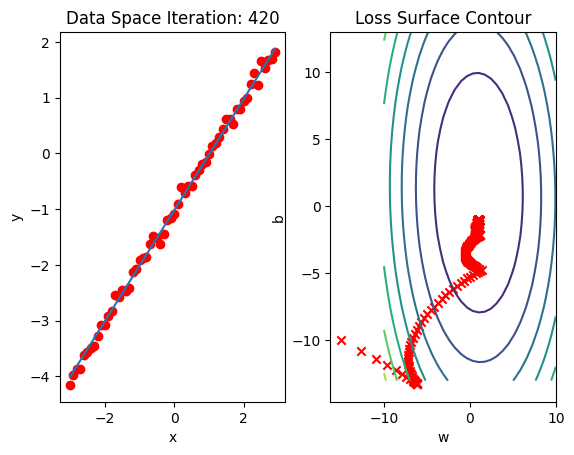

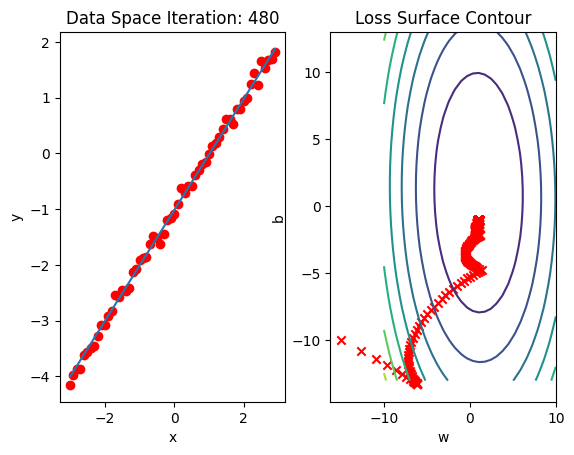

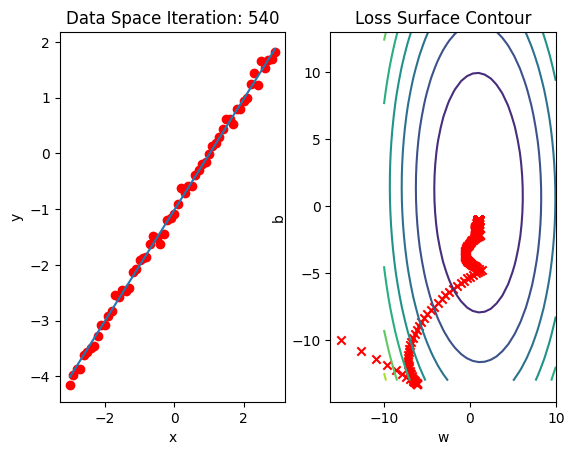

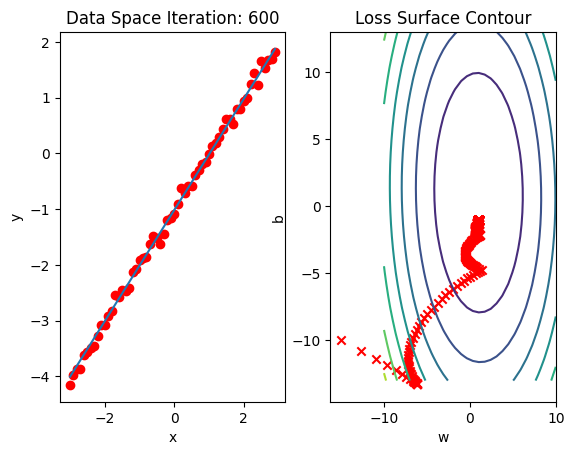

OrderedDict([('linear.weight', tensor([[0.9932]])),
             ('linear.bias', tensor([-1.0174]))])

In [ ]:
# Train Model

def train_model_BGD(iter):
    for epoch in range(iter):  # Loop over the number of epochs
        for x, y in trainloader:  # Loop over each batch from the DataLoader
            yhat = model(x)  # Forward pass: compute predictions
            loss = criterion(yhat, y)  # Compute the loss for this batch
            # Record current weight, bias, and loss for visualization
            get_surfaces.set_para_loss(
                model.state_dict()['linear.weight'][0].item(),  # Current weight value
                model.state_dict()['linear.bias'][0].item(),    # Current bias value
                loss.item()                                     # Current loss value
            )
            optimizer.zero_grad()  # Zero the gradients before backward pass
            loss.backward()        # Backward pass: compute gradients
            optimizer.step()       # Update model parameters (weight and bias)
        get_surfaces.plot_ps()     # Visualize parameter updates and loss surface after each epoch

train_model_BGD(10)  # Train the model for 10 epochs

model.state_dict()  # Output the final learned parameters (weight and bias)